# **Importação e Visualização dos Dados**

In [1]:
# !pip install --upgrade huggingface_hub
# !pip install datasets

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import io

FIG_NUMBER = 1
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [3]:
%%time
dataset = load_dataset("pierreguillou/DocLayNet-base", trust_remote_code=True)
# dataset = load_dataset("pierreguillou/DocLayNet-small", trust_remote_code=True)

CPU times: total: 922 ms
Wall time: 4.9 s


In [4]:
df_train = dataset['train'].to_pandas()
df_validation = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

## **Distribuição dos Dados**

In [5]:
doc_categories = df_train.doc_category.unique()
num_classes = len(doc_categories)

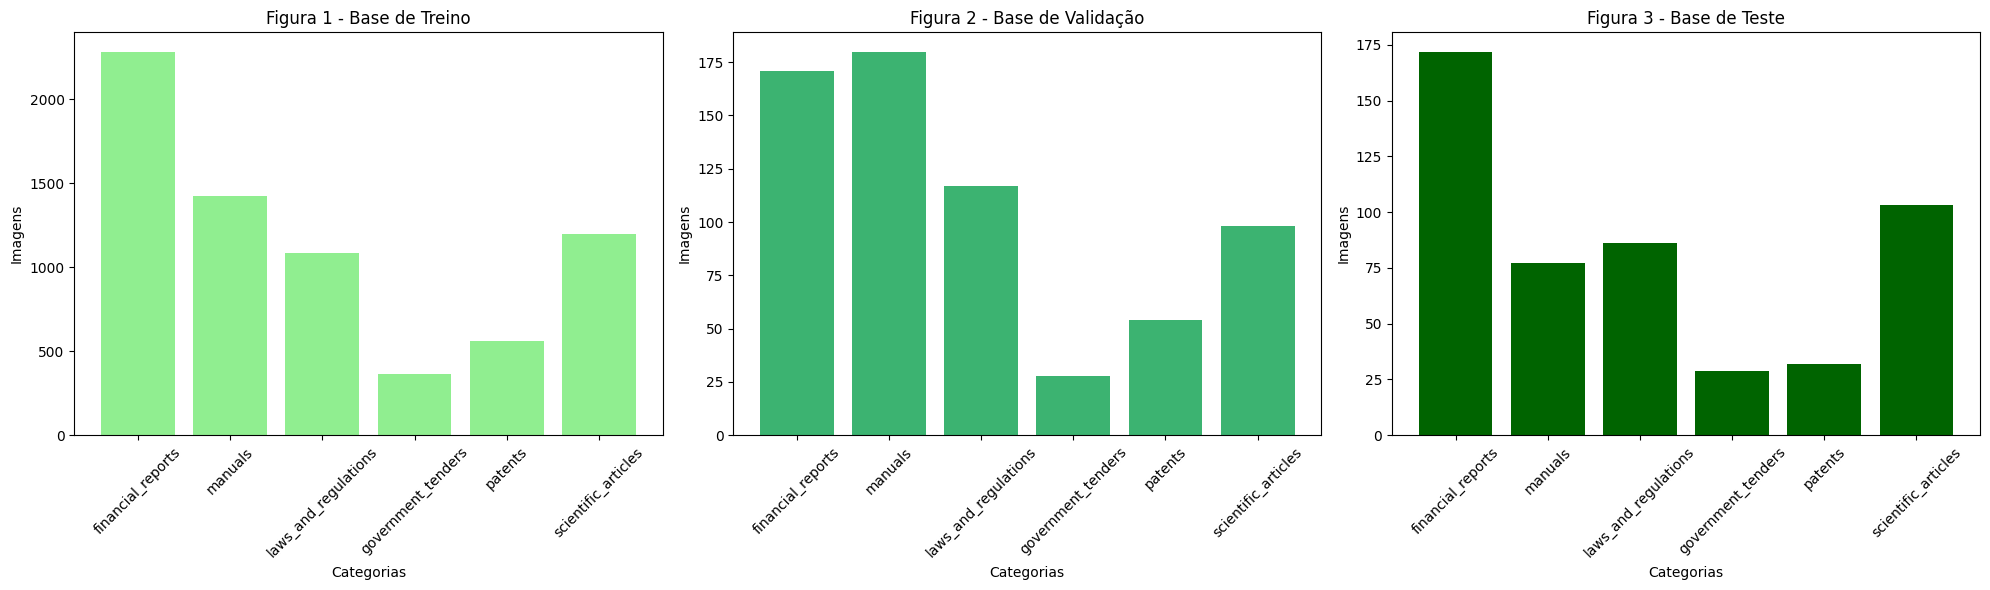

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

def plot_image_distribution(dataframe, axis, base_name, color):
    global FIG_NUMBER
    num_images = []
    for i in range(num_classes):
        class_data = dataframe[dataframe['doc_category'] == doc_categories[i]]
        count = class_data.shape[0]
        num_images.append(count)

    axs[axis].bar(doc_categories, num_images, color=f'{color}')
    axs[axis].set_xticks(range(len(doc_categories)))
    axs[axis].set_xticklabels(doc_categories, rotation=45)
    axs[axis].set_title(f'Figura {FIG_NUMBER} - Base de {base_name}')
    axs[axis].set_xlabel('Categorias')
    axs[axis].set_ylabel('Imagens')
    FIG_NUMBER += 1

plot_image_distribution(df_train, 0, 'Treino', 'lightgreen')
plot_image_distribution(df_validation, 1, 'Validação', 'mediumseagreen')
plot_image_distribution(df_test, 2, 'Teste', 'darkgreen')

plt.tight_layout()
plt.show()

In [7]:
class_data = df_train[df_train['doc_category'] == 'manuals']
print(class_data.shape[0])

class_data = df_validation[df_validation['doc_category'] == 'manuals']
print(class_data.shape[0])

class_data = df_test[df_test['doc_category'] == 'manuals']
print(class_data.shape[0])

1422
180
77


> - A distribuição das categorias de imagens é relativamente semelhante entre as bases, a categoria com mais disparidade é ***manuals***, sendo:  
> **1422** para a base de **treino**  
> **180** para a base de **validação**  
> **77** para a base de **teste**  

## **Pré Processamento da Imagem**

In [8]:
print(df_train['image'][0]['bytes'])
# array = np.array(df_train['image'][0]['bytes'])
# array = np.frombuffer(df_train['image'][0]['bytes'])
# array

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x01\x00\x00\x04\x01\x08\x02\x00\x00\x00\xd4\xe1\x04O\x00\x01\x00\x00IDATx\x9c\xec\xddw\x9c\x1cG\x9d(\xf0\xea<=9\xee\xcc\xec\xce\xe6\xac\xd5*\xe7hY\xc9\xb2\x9c\xb3\x8d\x03666\xc1\xf8\x1d\xc7#\x1dw\xc0\xdd\x01\x07\x98\xf080\xc6\x06\x03&9\'\xc9\xd9J\xb6r\x0e\xab\xcd9\xcd\xec\xe4\xdc\xb9\xeb\xfdQ\xd2x\xb4\x92l\xc0\t\xbc\xf5\xfd\xf0\xe1c\xcd\xf6tWWWW\xd7\xafB\x0f\x01!\x04\x18\x86a\x18\x86a\x18\x86M\x19\xe4G\x9d\x00\x0c\xc30\x0c\xc30\x0c\xc3>T8\x06\xc00\x0c\xc30\x0c\xc3\xb0\xa9\x05\xc7\x00\x18\x86a\x18\x86a\x186\xb5\xe0\x18\x00\xc30\x0c\xc30\x0c\xc3\xa6\x16\x1c\x03`\x18\x86a\x18\x86a\xd8\xd4\x82c\x00\x0c\xc30\x0c\xc30\x0c\x9bZp\x0c\x80a\x18\x86a\x18\x86aS\x0b\x8e\x010\x0c\xc30\x0c\xc30lj\xc11\x00\x86a\x18\x86a\x18\x86M-8\x06\xc00\x0c\xc30\x0c\xc3\xb0\xa9\x05\xc7\x00\x18\x86a\x18\x86a\x186\xb5\xe0\x18\x00\xc30\x0c\xc30\x0c\xc3\xa6\x16\x1c\x03`\x18\x86a\x18\x86a\xd8\xd4\x82c\x00\x0c\xc30\x0c\xc30\x0c\x9bZp\x0c\x80a\x18\x86a\x18\x86aS\x0b\x8e\x0

In [9]:
def get_png_array(df_row):
    png_bytes = df_row['bytes']

    # Converta os bytes da imagem em um objeto Image
    image = Image.open(io.BytesIO(png_bytes))
    
    grayscale_image = image.convert('L')
    
    # Redimensione a imagem
    resized_image = grayscale_image.resize((IMG_WIDTH, IMG_HEIGHT))

    # Converta a imagem redimensionada para um array NumPy
    image_array = np.array(resized_image)
    
    return image_array

In [10]:
df_train['image_array'] = df_train['image'].apply(lambda x: get_png_array(x))

In [11]:
df_validation['image_array'] = df_validation['image'].apply(lambda x: get_png_array(x))

## **Preparação dos Dados para Implementação de Rede Neural**

In [12]:
# x_train = df_train['image_array']
# y_train = df_train['doc_category']
x_train = np.stack(df_train['image_array'].values).astype(np.float32) / 255.0
x_val = np.stack(df_validation['image_array'].values).astype(np.float32) / 255.0

In [13]:
x_train = x_train.reshape((x_train.shape[0], IMG_WIDTH * IMG_HEIGHT))
x_val = x_val.reshape((x_val.shape[0], IMG_WIDTH * IMG_HEIGHT))

In [14]:
y_train = df_train['doc_category']
y_val = df_validation['doc_category']

In [15]:
# !pip install -U scikit-learn

In [16]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()

y_train_encoded = label_binarizer.fit_transform(y_train)
y_val_encoded = label_binarizer.fit_transform(y_val)

In [17]:
# !pip install --upgrade keras
# !pip install tensorflow

In [18]:
# Importando bibliotecas para criação e treinamento dos modelos
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay

In [19]:
# Criando tf.data.Dataset
batch_size = 500

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_encoded))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val_encoded))
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## **Rede Neural Artificial Densa**

In [22]:
neural_network_modelv2 = Sequential([
    Flatten(input_shape=(IMG_HEIGHT*IMG_WIDTH,)),
    Dropout(0.2),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

adam = Adam(learning_rate=0.001)
neural_network_modelv2.compile(optimizer=adam,
              loss=["categorical_crossentropy"],
              metrics=['accuracy'])

neural_network_modelv2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │    52,429,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,454,456 (200.10 MB)

 Trainable params: 52,454,456 (200.10 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
callback = EarlyStopping(monitor='loss', patience=5)
neural_network_historyv2 = neural_network_modelv2.fit(
    train_dataset,
    epochs=100,
    batch_size=500,
    shuffle=True,
    # verbose=0,
    validation_data=val_dataset,
    callbacks=[callback]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.3293 - loss: 1.6539 - val_accuracy: 0.2639 - val_loss: 1.6657
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3362 - loss: 1.6453 - val_accuracy: 0.2639 - val_loss: 1.6660
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3351 - loss: 1.6465 - val_accuracy: 0.2639 - val_loss: 1.6661
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.3330 - loss: 1.6445 - val_accuracy: 0.2639 - val_loss: 1.6661
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.3324 - loss: 1.6462 - val_accuracy: 0.2639 - val_loss: 1.6664
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.3317 - loss: 1.6468 - val_accuracy: 0.2639 - val_loss: 1.6666
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.3339 - loss: 1.6442 - val_accuracy: 0.2639 - val_loss: 1.6668
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.3340 - loss: 1.6447 - val_accuracy: 0.2639 - v

In [ ]:
""" callback = EarlyStopping(monitor='loss', patience=5)
neural_network_historyv2 = neural_network_modelv2.fit(np.array(x_train),
          np.array(y_train_encoded),
          epochs=100,
          batch_size=500,
          verbose=0,
          shuffle=True,
          validation_data=(np.array(x_val), np.array(y_val_encoded)),
          callbacks=[callback]) """

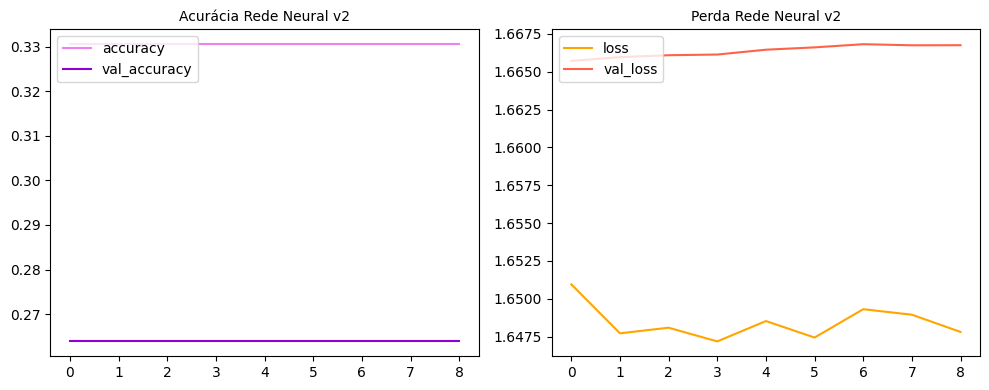

In [32]:
fig, axs = plt.subplots(1,2,figsize=(10, 4))
axs[0].plot(neural_network_historyv2.history['accuracy'], color='violet', label='accuracy')
axs[0].plot(neural_network_historyv2.history['val_accuracy'], color='darkviolet', label='val_accuracy')
axs[0].set_title('Acurácia Rede Neural v2', fontsize=10)

axs[1].plot(neural_network_historyv2.history['loss'], color='orange',label='loss')
axs[1].plot(neural_network_historyv2.history['val_loss'], color='tomato', label='val_loss')
axs[1].set_title('Perda Rede Neural v2', fontsize=10)

axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")
plt.tight_layout()
plt.show()